# Setup

In [19]:
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

In [2]:
pd.options.display.max_columns = 999

In [3]:
def display_df(df, n=1, tail=False, title=None):
    if title:
        print(title + ':')
    display(df.head(n), df.tail(n), df.shape) if tail else display(df.head(n), df.shape)

In [4]:
data_interim_dir = '../data/interim/'

# Read Data

In [5]:
df_interim = pd.read_csv(data_interim_dir + 'model_dataset.csv')
df_interim_sub = pd.read_csv(data_interim_dir + 'submission_dataset.csv')

In [6]:
display_df(df_interim, n=5, tail=True)
display_df(df_interim_sub, n=2)

,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Seed,Diff_NumOT
0,1985.0,1.0,1116.0,1234.0,9.0,8.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,1.0,0.0
1,1985.0,0.0,1116.0,1385.0,9.0,1.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,8.0,0.0
2,1985.0,1.0,1207.0,1385.0,1.0,1.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.0,0.0
3,1985.0,0.0,1246.0,1385.0,12.0,1.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.77772

,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Seed,Diff_NumOT
2137,2018.0,0.0,1139.0,1345.0,10.0,2.0,14.000000,12.696970,2.939394,3.363636,24.787879,24.575758,61.848485,23.000000,21.000000,55.939394,29.212121,8.181818,7.848485,25.181818,16.242424,19.636364,12.515152,14.575758,0.181818,9.212121,8.121212,18.242424,16.878788,79.121212,72.787879,6.727273,5.151515,11.181818,14.151515,16.705882,12.029412,5.029412,2.382353,26.588235,22.029412,56.705882,22.823529,20.588235,59.794118,28.176471,9.588235,6.941176,24.529412,20.470588,14.205882,15.205882,9.647059,0.029412,8.441176,10.441176,15.529412,18.647059,81.147059,65.647059,5.823529,5.205882,10.676471,12.088235,-2.705882,0.667558,-2.090018,0.981283,-1.800357,2.546346,5.142602,-3.854724,0.176471,0.411765,1.035651,0.652406,-1.406417,0.907308,-4.228164,5.430481,-2.690731,4.928699,0.770945,-2.319964,2.713012,-1.768271,-2.025847,7.140820,0.903743,-0.054367,0.505348,2.063280,8.0,0.152406
2138,2018.0,1.0,1393.0,1395.0,11.0,6.0,10.969697,16.181818,5.575758,3.181818,25.333333,22.393939,54.424242,18.181818,24.181818,55.272727,22.757576,5.848485,7.939394,21.878788,21.848485,17.303030,16.181818,12.848485,0.121212,12.090909,10.484848,16.303030,18.393939,67.545455,64.545455,7.242424,6.303030,12.575758,12.848485,18.781250,15.718750,3.593750,4.250000,25.187500,21.312500,60.156250,21.156250,21.343750,59.406250,30.000000,8.468750,8.093750,27.281250,20.531250,18.218750,14.531250,13.281250,0.156250,11.250000,8.812500,16.906250,18.625000,83.000000,75.937500,6.593750,6.250000,12.687500,12.593750,-7.811553,0.463068,1.982008,-1.068182,0.145833,1.081439,-5.732008,-4.133523,-2.974432,2.838068,-7.242424,-5.402462,-2.620265,-0.154356,1.317235,-0.915720,1.650568,-0.432765,0.840909,1.672348,-0.603220,-0.231061,-15.454545,-11.392045,0.648674,0.053030,-0.111742,0.254735,5.0,-0.035038
2139,2018.0,1.0,1420.0,1438.0,16.0,1.0,14.870968,13.580645,2.548387,2.806452,24.354839,27.129032,58.451613,25.774194,23.161290,56.612903,25.612903,9.838710,8.322581,25.322581,17.580645,17.580645,11.419355,12.000000,0.000000,9.709677,9.935484,16.516129,18.774194,72.483871,70.967742,7.387097,6.258065,11.677419,14.322581,13.727273,8.848485,3.727273,2.636364,24.272727,22.212121,54.181818,18.878788,20.303030,50.151515,25.000000,7.363636,6.151515,18.818182,13.424242,13.121212,10.181818,9.606061,0.030303,8.393939,8.393939,14.060606,15.060606,67.545455,53.393939,6.787879,3.878788,8.575758,12.727273,1.143695,4.732160,-1.178886,0.170088,0.082111,4.916911,4.269795,6.461388,6.895406,2.858260,0.612903,6.504399,2.475073,2.171065,4.156403,4.459433,1.237537,2.393939,1.315738,1.541544,2.455523,3.713587,4.938416,17.573803,0.599218,2.379277,3.101662,1.595308,15.0,-0.030303
2140,2018.0,1.0,1243.0,1420.0,9.0,16.0,14.333333,12.666667,3.000000,2.454545,22.393939,23.060606,54.878788,20.181818,21.363636,53.787879,25.878788,6.939394,7.090909,23

(2142, 94)

,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Seed,Diff_NumOT
0,2014,1107,1110,16,15,11.0625,12.34375,3.0625,3.03125,24.21875,21.59375,51.09375,13.46875,19.59375,54.34375,22.4375,4.90625,6.90625,22.75,21.71875,15.84375,16.25,11.4375,0.09375,10.34375,9.9375,17.25,19.25,66.03125,63.84375,5.53125,5.84375,12.625,11.96875,15.125000,10.093750,3.437500,2.437500,22.937500,19.312500,46.5625,16.593750,15.062500,49.03125,23.031250,6.343750,4.718750,20.156250,16.250000,20.187500,11.531250,13.593750,0.031250,7.125000,9.781250,17.218750,17.625000,63.937500,58.625000,6.031250,7.031250,13.968750,12.125000,-4.062500,2.250000,-0.375000,0.593750,1.281250,2.281250,4.53125,5.31250,-3.125000,4.531250,-0.593750,2.593750,-1.437500,2.187500,5.468750,-4.343750,4.718750,-2.156250,3.218750,0.156250,0.031250,1.625000,2.093750,5.218750,-0.500000,-1.187500,-1.343750,-0.156250,1,0.062500
1,2014,1107,1112,16,1,11.0625,12.34375,3.0625,3.03125,24.21875,21.59375,51.09375,13.46875,19.59375,54.34375,22.4375,4.90625,6.90625,22.75,21.71875,15.84375,16.25,11.4375,0.09375,10.34375,9.9375,17.25,19.25,66.03125,63.84375,5.53125,5.84375,12.625,11.96875,15.088235,9.176471,4.235294,3.176471,26.294118,21.205882,56.0000,14.852941,14.029412,53.50000,26.235294,5.294118,4.411765,20.382353,23.352941,18.441176,15.294118,12.970588,0.088235,12.588235,9.235294,16.441176,18.617647,73.058824,58.147059,5.882353,4.764706,10.441176,12.411765,-4.025735,3.167279,-1.172794,-0.145221,-2.075368,0.387868,-4.90625,0.84375,-1.384191,5.564338,-3.797794,2.367647,-0.387868,2.494485,-1.634191,-2.597426,0.955882,-1.533088,-2.244485,0.702206,0.808824,0.632353,-7.027574,5.696691,-0.351103,1.079044,2.183824,-0.443015,15,0.005515


(11390, 93)

# Train / Validation Split

In [7]:
df_train = df_interim.loc[df_interim.Season.isin(np.arange(1985, 2014))]
df_valid = df_interim.loc[df_interim.Season.isin(np.arange(2014, 2019))]

# Train Model

In [38]:
features = list(set(df_interim.columns) - set(['Label', 'Season', 'TeamOneID', 'TeamTwoID']))

In [65]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=3)
y_train = df_train.Label.values
X_train = df_train[features].values
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

# Analyze Model

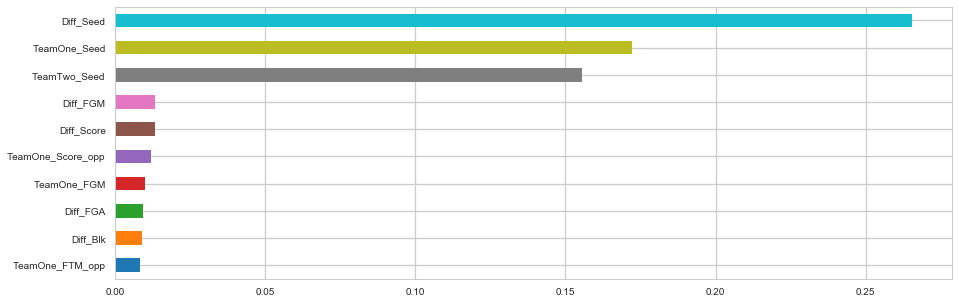

In [95]:
(
    pd.Series(clf.feature_importances_, index=df_train[features].columns)
    .nlargest(n=10)
    .sort_values()
    .plot(kind='barh', figsize=(15, 5), fontsize=10)

)
plt.show()

# Produce Scores

In [98]:
def clip_preds(y):
    return np.clip(y, 0.05, 0.95)

In [99]:
# Train score
yp_train = clip_preds(clf.predict_proba(X_train)[:, 1])
score_train = log_loss(y_train, yp_train, normalize=True)
print(score_train)

0.459857723034


In [100]:
y_valid = df_valid.Label.values
X_valid = df_valid[features].values

# Validation score
yp_valid = clip_preds(clf.predict_proba(X_valid)[:, 1])
score_valid = log_loss(y_valid, yp_valid, normalize=True)
print(score_valid)

0.59689695105


# Save Model and Submission File

In [101]:
model_name = "clf_v2"

In [102]:
# Save model
outfile = open('../models/{name}.model'.format(name=model_name), 'wb')
pickle.dump(clf, outfile)
outfile.close()

In [107]:
# Create submission file
def create_ID(row):
    """TBD"""
    return str(row.Season.astype(int)) + '_' + str(row.TeamOneID.astype(int)) + '_' + str(row.TeamTwoID.astype(int))


X_sub = df_interim_sub[features].values

df_final_sub = (
    df_interim_sub
    .assign(Pred=clip_preds(clf.predict_proba(X_sub)[:, 1]))
    .assign(ID=df_interim_sub.apply(create_ID, axis=1))
    .loc[:, ['ID', 'Pred']]
)

In [108]:
# Save submssion file
df_final_sub.to_csv('../models/{name}_submission.csv'.format(name=model_name), index=False)